In [1]:
#%%imports
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from lstein import (
    utils as lsu,
    makedata as md
)
from lstein import lstein
importlib.reload(lstein)

# plt.style.use("dark_background")

<module 'lstein.lstein' from '/home/lukas/github/LStein/src/lstein/lstein.py'>

# Get the Data

In [2]:
#%%data loading
def get_data(fidx:int):
    """
        - function to load some data
    """

    xmin2zero = False   #whether to shift xvalues to start at 0

    #passbands
    df_pb = pl.read_csv("../data/passband_specs.csv")
    passbands = list(df_pb["name"])
    pb_mappings = dict(zip(df_pb["wavelength"], df_pb.select(pl.exclude("wavelength")).to_numpy()))

    #LCs
    fnames = sorted(glob.glob("../data/*_*.csv"))
    fnames = np.append(fnames, ["../data/lc_simulated.py", "../data/sin_simulated.py"])
    # print(fnames)
    fname = fnames[fidx]

    #deal with on-the-fly data generation (pseudo filenames)
    if fname == "../data/lc_simulated.py":
        raw, pro = md.simulate(5, opt="lc")
        df = pl.concat([pl.from_dict(raw), pl.from_dict(pro)])
        for t in df["period"].unique(): pb_mappings[t] = [np.round(t, 3)]
        legend = False
        thetalab = "Maximum Amplitude"
        xlab = "Time [d]"
        ylab = "Amplitude []"
    elif fname == "../data/sin_simulated.py":
        raw, pro = md.simulate(5, opt="sin")
        df = pl.concat([pl.from_dict(raw), pl.from_dict(pro)])
        for t in df["period"].unique(): pb_mappings[t] = [np.round(t, 3)]
        legend = False
        thetalab = "Period [s]"
        xlab = "Time [s]"
        ylab = "Amplitude []"
    else:
        df = pl.read_csv(fname, comment_prefix="#")
        df = df.sort(pl.col(df.columns[1]))
        legend = True
        thetalab = "Wavelength [nm]"
        xlab = "MJD-min(MJD) [d]" if "mjd" in df.columns else "Period [d]"
        ylab = "m [mag]" if "mag" in df.columns else "Fluxcal []"

    # df = df.drop_nans()

    # #sigma clipping
    # df = df.filter(
    #     pl.col(df.columns[2]).median()-3*pl.col(df.columns[2]).std() <= pl.col(df.columns[2]),
    #     pl.col(df.columns[2]) <= pl.col(df.columns[2]).median()+3*pl.col(df.columns[2]).std(),
    # )

    # parts = re.split(r"[/\_\.]", fname)
    # survey = parts[-2]
    # otype = parts[-3]

    df_raw = df.filter(pl.col("processing")=="raw")
    df_pro = df.filter(pl.col("processing")!="raw")
    theta_raw = np.sort(np.unique(df_raw[:,0]))
    df_raw_p = df_raw.partition_by(df_raw.columns[0], maintain_order=True)
    x_raw = [df[:,1].to_numpy().astype(np.float64) for df in df_raw_p]
    x_raw = [xi - xmin2zero*np.nanmin(xi) for xi in x_raw]
    y_raw = [df[:,2].to_numpy().astype(np.float64) for df in df_raw_p]
    theta_pro = np.sort(np.unique(df_pro[:,0]))
    df_pro_p = df_pro.partition_by(df_pro.columns[0], maintain_order=True)
    x_pro = [df[:,1].to_numpy().astype(np.float64) for df in df_pro_p]
    x_pro = [xi - xmin2zero*np.nanmin(xi) for xi in x_pro]
    y_pro = [df[:,2].to_numpy().astype(np.float64) for df in df_pro_p]
    
    #artificial, large x-values
    # x_raw = [np.linspace(10000,10010,len(xi)) for xi in x_raw]
    # x_pro = [np.linspace(10000,10010,len(xi)) for xi in x_pro]

    return (
        theta_raw, x_raw, y_raw,
        theta_pro, x_pro, y_pro,
        legend, thetalab, xlab, ylab, fname,
    )

theta_raw, x_raw, y_raw, \
theta_pro, x_pro, y_pro, \
legend, thetalab, xlab, ylab, fname = get_data(-1)

In [3]:
#%%get stats
def get_stats(theta_raw, x_raw, y_raw, fname):
    """
        - function to get stats for plot specifications
    """
    unique_thetas = np.unique(theta_raw)
    thetaticks = np.round(np.linspace(np.floor(np.min(theta_raw)), np.ceil(np.max(theta_raw)), 4),0).astype(int)
    xticks = np.round(np.linspace(np.floor(np.min(np.concat(x_raw))), np.ceil(np.max(np.concat(x_raw))), 4), decimals=0).astype(int)
    yticks = np.round(np.linspace(np.floor(np.min(np.concat(y_raw))), np.ceil(np.max(np.concat(y_raw))), 4), decimals=0).astype(int)
    # yticks = np.sort(np.append(yticks, [-10, 80]))
    panelsize = np.pi/10
    vmin = 300 if ".py" not in fname else None
    colors = lsu.get_colors(theta_raw, cmap="nipy_spectral", vmin=vmin)
    return (
        unique_thetas,
        thetaticks, xticks, yticks,
        panelsize,
        colors,
    )

unique_thetas, \
thetaticks, xticks, yticks, \
panelsize, \
colors = get_stats(theta_raw, x_raw, y_raw, fname)
print(xticks)

[-50   0  50 100]


# Standard Usage

/tmp/ipykernel_50124/610731465.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


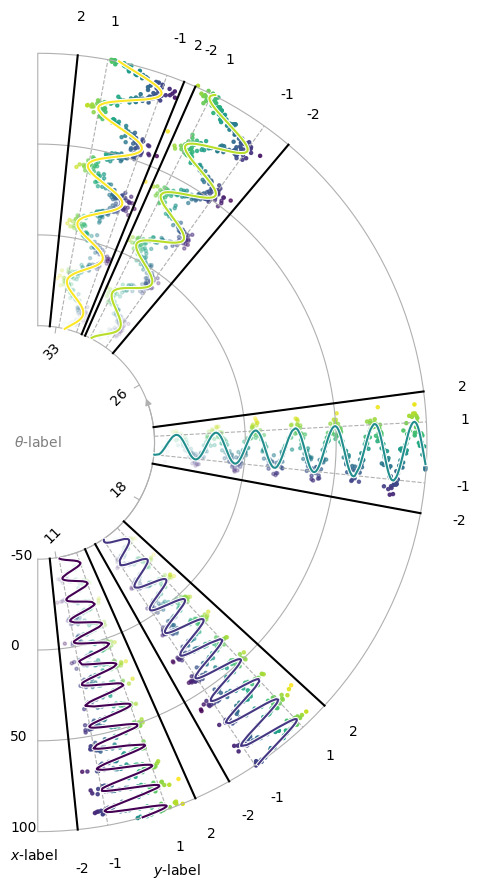

In [4]:
#init canvas (similar to `fig = plt.figure()`)
LSC = lstein.LSteinCanvas(
    thetaticks,
    xticks=xticks,                          #use as ticks and labels
    # xticks=[-20,0,20,100],                  #custom (also use as labels)
    # xticks=(xticks,["x1","x2","x3","x4"]),  #custom labels
    yticks=yticks,
    thetaguidelims=(-np.pi/2,np.pi/2), thetaplotlims=(-np.pi/2+panelsize/2,np.pi/2-panelsize/2),
    xlimdeadzone=0.3,
    thetalabel=r"$\theta$-label", xlabel=r"$x$-label", ylabel=r"$y$-label",
    thetaarrowpos_th=25, ylabpos_th=np.min(theta_raw),
    thetatickkwargs=dict(ls="-"), thetaticklabelkwargs=dict(rotation=45), thetalabelkwargs=dict(c="tab:grey"),
    xtickkwargs=dict(ls="-"), xticklabelkwargs=dict(xytext=(-2,0)), xlabelkwargs=dict(c="k"),
)

#get colors for colormapping `theta`
colors = lsu.get_colors(theta_raw)

#add different panels
for i in range(len(theta_raw)):
    
    #add a panel (similar to `ax = fig.add_subplot()`)
    LSP = LSC.add_panel(
        theta=theta_raw[i],
        yticks=None,                                                #as initialized in `LSteinCanvas`
        # yticks=yticks,                                              #predifined (use also as labels)
        # yticks=[np.floor(y_raw[i].min()), np.ceil(y_raw[i].max())], #data fills the entire panel
        # yticks=(yticks, ["A", "B", "C", "D"]),                      #predifined (custom labels)
        panelsize=panelsize,
        show_panelbounds=True, show_yticks=True,
        # y_projection_method="theta",                                #execute projection in theta-space (preferred)
        y_projection_method="y",                                    #execute projection in y-space
        ytickkwargs=dict(ls="--"), yticklabelkwargs=None,
        panelboundskwargs=None,
    )

    #add a seroes to the panel
    LSP.plot(x_raw[i], y_raw[i], seriestype="scatter", c=y_raw[i], s=5,  alpha=np.linspace(0, 1, y_raw[i].shape[0]))
    LSP.plot(x_pro[i], y_pro[i], seriestype="plot", c="w", lw=3)
    LSP.plot(x_pro[i], y_pro[i], seriestype="plot", color=colors[i])
    # LSP.plot(x_pro[i], y_pro[i], seriestype="bar", color=colors[i])

fig = lstein.draw(LSC, figsize=(5,9))
fig.tight_layout()
fig.show()

# Convenience Usage


/tmp/ipykernel_50124/2183376300.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


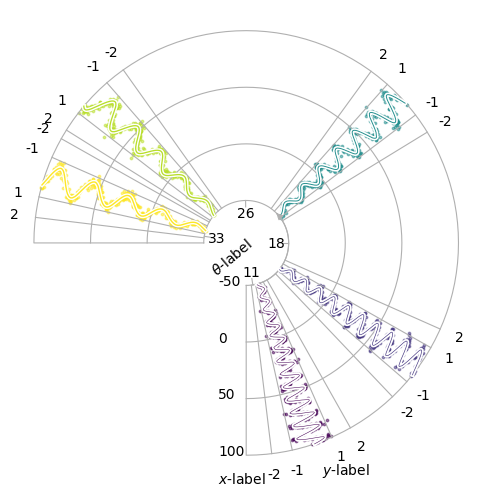

In [5]:
#init canvas (similar to `fig = plt.figure()`)
LSC = lstein.LSteinCanvas(
    thetaticks, xticks, yticks,
    thetaguidelims=(-np.pi/2,2*np.pi/2), thetaplotlims=(-np.pi/2+panelsize/2,2*np.pi/2-panelsize/2),
    xlimdeadzone=0.2,
    thetalabel=r"$\theta$-label", xlabel=r"$x$-label", ylabel=r"$y$-label",
    thetaarrowpos_th=None, ylabpos_th=np.min(theta_raw),
    thetatickkwargs=None, thetaticklabelkwargs=dict(pad=0.3), thetalabelkwargs=dict(rotation=40, textcoords="offset fontsize", xytext=(-1,-1)),
    xtickkwargs=None, xticklabelkwargs=dict(xytext=(-2,0)), xlabelkwargs=None,
)

#adding all the series (will initialize panels for you)
LSC.plot(theta_raw, x_raw, y_raw, seriestype="scatter", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=dict(s=3, alpha=0.5))
LSC.plot(theta_pro, x_pro, y_pro, seriestype="plot", series_kwargs=dict(lw=3, c="w"))
LSC.plot(theta_pro, x_pro, y_pro, seriestype="plot", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=[dict(lw=_/theta_pro.max(), ls="-") for _ in theta_pro])

fig = lstein.draw(LSC, figsize=(5,9))
fig.tight_layout()
fig.show()


# Customizations

## Axis Inversion
* for inversion of the x- and y-axis simply pass reverse sorted `xticks` and/or `yticks`
* for inversion of the $\theta$-axis pass the following:
    * `thetaguidelims[0] > thetaguidelims[1]`
    * `thetaplotlims[0] > thetaplotlims[1]`

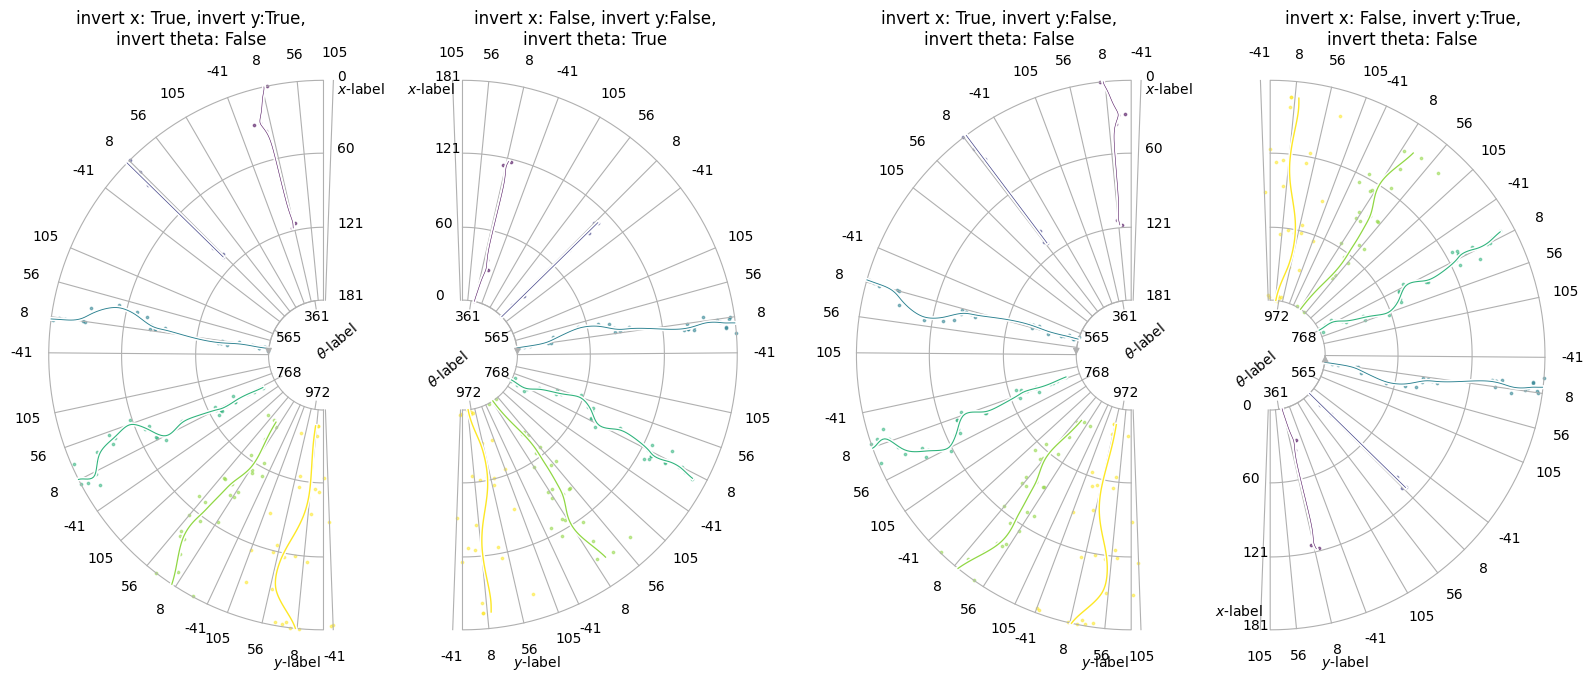

In [6]:
theta_raw, x_raw, y_raw, \
theta_pro, x_pro, y_pro, \
legend, thetalab, xlab, ylab, fname = get_data(7)

unique_thetas, \
thetaticks, xticks, yticks, \
panelsize, \
colors = get_stats(theta_raw, x_raw, y_raw, fname)

#init canvas (similar to `fig = plt.figure()`)
##inverting x-axis and y-axis (because more readable)
LSC1 = lstein.LSteinCanvas(
    thetaticks, xticks[::-1], yticks[::-1],
    thetaguidelims=(np.pi/2,3*np.pi/2), thetaplotlims=(np.pi/2+panelsize/2,3*np.pi/2-panelsize/2),
    xlimdeadzone=0.2,
    thetalabel=r"$\theta$-label", xlabel=r"$x$-label", ylabel=r"$y$-label",
    thetaarrowpos_th=None, ylabpos_th=np.max(theta_raw),
    thetatickkwargs=None, thetaticklabelkwargs=dict(pad=0.3), thetalabelkwargs=dict(rotation=40, textcoords="offset fontsize", xytext=(1,1)),
    xtickkwargs=None, xticklabelkwargs=dict(xytext=(1,0)), xlabelkwargs=dict(xytext=(1,-1)),
)

##invesion in theta
LSC2 = lstein.LSteinCanvas(
    thetaticks, xticks, yticks,
    thetaguidelims=(np.pi/2,-np.pi/2), thetaplotlims=(np.pi/2-panelsize/2,-np.pi/2+panelsize/2),
    xlimdeadzone=0.2,
    thetalabel=r"$\theta$-label", xlabel=r"$x$-label", ylabel=r"$y$-label",
    thetaarrowpos_th=None, ylabpos_th=np.max(theta_raw),
    thetatickkwargs=None, thetaticklabelkwargs=dict(pad=0.3), thetalabelkwargs=dict(rotation=40, textcoords="offset fontsize", xytext=(-1,-1)),
    xtickkwargs=None, xticklabelkwargs=dict(xytext=(-2,0)), xlabelkwargs=dict(xytext=(-4,-1)),
)
##inverting only x-axis
LSC3 = lstein.LSteinCanvas(
    thetaticks, xticks[::-1], yticks,
    thetaguidelims=(np.pi/2,3*np.pi/2), thetaplotlims=(np.pi/2+panelsize/2,3*np.pi/2-panelsize/2),
    xlimdeadzone=0.2,
    thetalabel=r"$\theta$-label", xlabel=r"$x$-label", ylabel=r"$y$-label",
    thetaarrowpos_th=None, ylabpos_th=np.max(theta_raw),
    thetatickkwargs=None, thetaticklabelkwargs=dict(pad=0.3), thetalabelkwargs=dict(rotation=40, textcoords="offset fontsize", xytext=(1,1)),
    xtickkwargs=None, xticklabelkwargs=dict(xytext=(1,0)), xlabelkwargs=dict(xytext=(1,-1)),
)

##inverting only y-axis
LSC4 = lstein.LSteinCanvas(
    thetaticks, xticks, yticks[::-1],
    thetaguidelims=(-np.pi/2,np.pi/2), thetaplotlims=(-np.pi/2+panelsize/2,np.pi/2-panelsize/2),
    xlimdeadzone=0.2,
    thetalabel=r"$\theta$-label", xlabel=r"$x$-label", ylabel=r"$y$-label",
    thetaarrowpos_th=None, ylabpos_th=np.min(theta_raw),
    thetatickkwargs=None, thetaticklabelkwargs=dict(pad=0.3), thetalabelkwargs=dict(rotation=40, textcoords="offset fontsize", xytext=(-1,-1)),
    xtickkwargs=None, xticklabelkwargs=dict(xytext=(-2,0)), xlabelkwargs=dict(xytext=(-4,1)),
)

#plotting all the series (similar to `plt.plot()`)
LSC1.plot(theta_raw, x_raw, y_raw, seriestype="scatter", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=dict(s=3, alpha=0.5))
LSC1.plot(theta_pro, x_pro, y_pro, seriestype="plot", series_kwargs=dict(lw=3, c="w"))
LSC1.plot(theta_pro, x_pro, y_pro, seriestype="plot", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=[dict(lw=_/theta_pro.max(), ls="-") for _ in theta_pro])
LSC2.plot(theta_raw, x_raw, y_raw, seriestype="scatter", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=dict(s=3, alpha=0.5))
LSC2.plot(theta_pro, x_pro, y_pro, seriestype="plot", series_kwargs=dict(lw=3, c="w"))
LSC2.plot(theta_pro, x_pro, y_pro, seriestype="plot", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=[dict(lw=_/theta_pro.max(), ls="-") for _ in theta_pro])
LSC3.plot(theta_raw, x_raw, y_raw, seriestype="scatter", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=dict(s=3, alpha=0.5))
LSC3.plot(theta_pro, x_pro, y_pro, seriestype="plot", series_kwargs=dict(lw=3, c="w"))
LSC3.plot(theta_pro, x_pro, y_pro, seriestype="plot", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=[dict(lw=_/theta_pro.max(), ls="-") for _ in theta_pro])
LSC4.plot(theta_raw, x_raw, y_raw, seriestype="scatter", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=dict(s=3, alpha=0.5))
LSC4.plot(theta_pro, x_pro, y_pro, seriestype="plot", series_kwargs=dict(lw=3, c="w"))
LSC4.plot(theta_pro, x_pro, y_pro, seriestype="plot", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=[dict(lw=_/theta_pro.max(), ls="-") for _ in theta_pro])

fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(141, title="invert x: True, invert y:True,\ninvert theta: False")
ax2 = fig.add_subplot(142, title="invert x: False, invert y:False,\ninvert theta: True")
ax3 = fig.add_subplot(143, title="invert x: True, invert y:False,\ninvert theta: False")
ax4 = fig.add_subplot(144, title="invert x: False, invert y:True,\ninvert theta: False")

lstein.LSteinMPL(LSC1).show(ax1)
lstein.LSteinMPL(LSC2).show(ax2)
lstein.LSteinMPL(LSC3).show(ax3)
lstein.LSteinMPL(LSC4).show(ax4)

fig.tight_layout()
plt.show()

# Other Nuances

### `y_projection_method`

Depending on which method you use, different behaviors are to be expected.
Options are the following:

* `"theta"`
    * method:
        1. transform original series into $\theta$-space (polar coordinates)
        2. apply rescaling to project data into respective panel
        3. transform back into $y$-space (carthesian coordinates) for plotting
    * behavior:
        * distorsion in x-direction
            * note the asymmetry of the wave-mountains and -valleys
        * accurate representation in y-direction
        * goes haywire for large x-values due to computation of $\tan$ and $arc\tan$ when converting between coordinate systems
* `"y"`
    * method:
        1. apply rescaling to project data into respective panel onto original data (carthesian coordinates)
        2. project to $\theta$-space (polar coordinates) to add the $\theta$-offset (for panel positioning)
        3. transform back into $y$-space (carthesian coordinates) for plotting
    * behavior:
        * no distorsion in x-direction
            * wave-mountains and -valleys stay symmetrical
        * projections effects in y-direction
            * especially when overplotting several series
            * may lead to unexpected offsets between dataseries

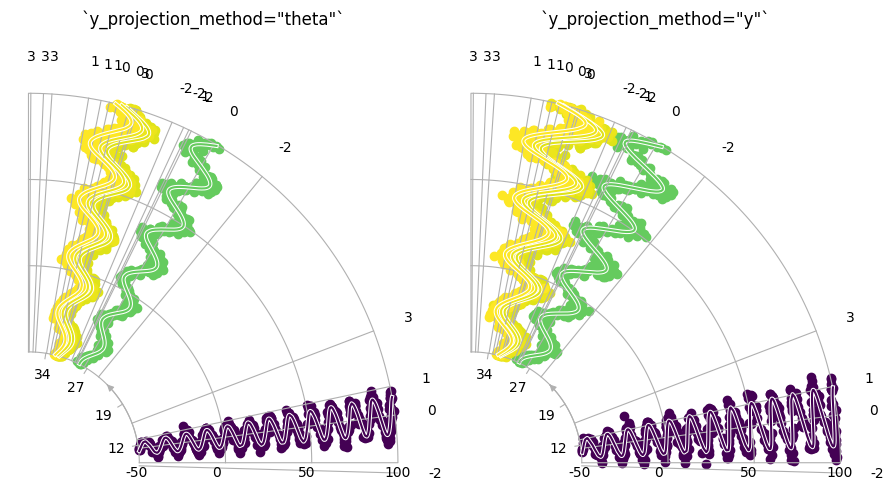

In [7]:
fidx = 0    #displays projection effects in y-direction with `y_projection_method="y"`
fidx = -1   #displays projection effects in x-projection with `y_projection_method="theta"`
# fidx = 8    #displays going haywire for large x-values

#get data
theta_raw, x_raw, y_raw, \
theta_pro, x_pro, y_pro, \
legend, thetalab, xlab, ylab, fname = get_data(fidx)

unique_thetas, \
thetaticks, xticks, yticks, \
panelsize, \
colors = get_stats(theta_raw, x_raw, y_raw, fname)

#init canvas (similar to `fig = plt.figure()`)
LSC1 = lstein.LSteinCanvas(
    thetaticks, xticks, yticks,
    thetaguidelims=(0,np.pi/2), thetaplotlims=(0+panelsize/2,np.pi/2-panelsize/2),
)
LSC2 = lstein.LSteinCanvas(
    thetaticks, xticks, yticks,
    thetaguidelims=(0,np.pi/2), thetaplotlims=(0+panelsize/2,np.pi/2-panelsize/2),
)

#plotting all the series (similar to `plt.plot()`)
LSC1.plot(theta_raw[::1], x_raw[::1], y_raw[::1], seriestype="scatter", panel_kwargs=dict(y_projection_method="theta"),)
LSC1.plot(theta_pro[::1], x_pro[::1], y_pro[::1], seriestype="plot", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=dict(lw=3, c="w"))
LSC1.plot(theta_pro[::1], x_pro[::1], y_pro[::1], seriestype="plot", panel_kwargs=dict(y_projection_method="theta"),)
LSC2.plot(theta_raw[::1], x_raw[::1], y_raw[::1], seriestype="scatter", panel_kwargs=dict(y_projection_method="y"),)
LSC2.plot(theta_pro[::1], x_pro[::1], y_pro[::1], seriestype="plot", panel_kwargs=dict(y_projection_method="y"), series_kwargs=dict(lw=3, c="w"))
LSC2.plot(theta_pro[::1], x_pro[::1], y_pro[::1], seriestype="plot", panel_kwargs=dict(y_projection_method="y"),)

#plotting
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title("`y_projection_method=\"theta\"`", y=1.1)
ax2.set_title("`y_projection_method=\"y\"`", y=1.1)

lstein.LSteinMPL(LSC1).show(ax1)
lstein.LSteinMPL(LSC2).show(ax2)
fig.tight_layout()
plt.show()


# Other Datasets

/tmp/ipykernel_50124/3105136896.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


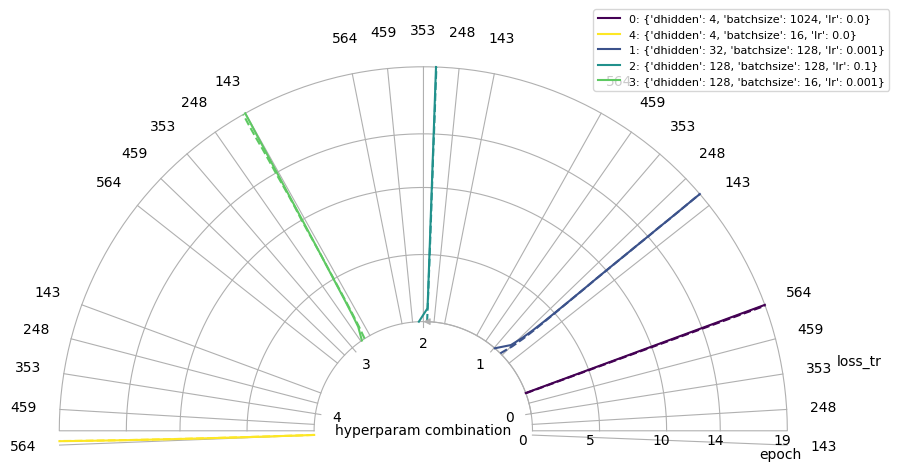

In [8]:
df = pl.read_csv("../data/autoencoder_hypsearch.csv").with_columns(
    pl.col("hyperparameters").cast(pl.Categorical).to_physical().alias("hyperparam combination")
).select(pl.col("hyperparam combination"), pl.exclude("hyperparameters", "hyperparam combination"), pl.col("hyperparameters"))
dfs = df.partition_by(df.columns[0], maintain_order=True)

y1idx = 2
y2idx = 3
theta       = [d[0,0] for d in dfs]
X           = [d[:,1].to_numpy().flatten() for d in dfs]
Y           = [d[:,y1idx].to_numpy().flatten() for d in dfs]
Y2          = [d[:,y2idx].to_numpy().flatten() for d in dfs]

thetalabs   = [d[0,-1] for d in dfs]

thetaticks  = np.round(np.linspace(df[:,0].min(), df[:,0].max(), 5), decimals=0).astype(int)
xticks      = np.round(np.linspace(df[:,1].min(), df[:,1].max(), 5), decimals=0).astype(int)
yticks      = np.round(np.linspace(df[:,y1idx].min(), df[:,y1idx].max(), 5), decimals=0).astype(int)



LSC = lstein.LSteinCanvas(
    thetaticks, xticks, yticks,
    thetaguidelims=(0,2*np.pi/2), thetaplotlims=(0+panelsize/2,2*np.pi/2-panelsize/2),
    thetalabel=df.columns[0], xlabel=df.columns[1], ylabel=df.columns[y1idx],
)
LSC.plot(theta, X, Y, series_kwargs=[dict(label=f"{theta[i]}: {thetalabs[i]}") for i in range(len(theta))])
LSC.plot(theta, X, Y2, series_kwargs=dict(ls="--"))

fig = lstein.draw(LSC, figsize=(9,9))
fig.tight_layout()
fig.show()
fig.legend(bbox_to_anchor=(1.0,0.78), fontsize=8)

plt.show()